In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')

In [2]:
df_train = pd.read_csv('train.csv')
df_train[:5]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Amount,Class
0,-0.360935,0.414121,0.350526,-0.301530,0.807420,-0.980730,1.119891,-0.436637,-0.176753,-0.153670,-0.575059,-0.123297,-0.097962,0.298767,-0.343608,0
1,1.018400,-0.171383,-1.316673,0.359771,0.272607,-0.709163,0.410782,-0.298290,0.544704,0.131873,-1.764381,-0.598515,-1.313729,0.684423,-0.060945,0
2,0.025131,0.536588,0.157795,-0.440282,0.372151,-0.763276,0.850493,-0.195224,-0.112704,-0.394862,-0.939771,0.394708,0.617532,-0.012528,-0.319157,0
3,-0.507058,0.572257,0.581543,-0.977343,-0.332314,-0.516672,-0.007617,0.504860,0.010311,-0.349577,0.676610,0.328619,-0.748642,0.518961,-0.317194,0
4,-0.852951,0.165384,0.782056,-1.871645,-1.033465,0.223664,-1.026572,1.054989,-2.355760,0.735550,1.061064,-0.261007,0.032071,0.280895,-0.275042,0


In [3]:
print('0: %d\n1: %d' % tuple(df_train['Class'].value_counts()))
print('total: %d' % len(df_train))

0: 227454
1: 391
total: 227845


In [4]:
df_features = df_train.drop(['Amount', 'Class'], axis=1)
df_features[:5]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
0,-0.360935,0.414121,0.350526,-0.301530,0.807420,-0.980730,1.119891,-0.436637,-0.176753,-0.153670,-0.575059,-0.123297,-0.097962,0.298767
1,1.018400,-0.171383,-1.316673,0.359771,0.272607,-0.709163,0.410782,-0.298290,0.544704,0.131873,-1.764381,-0.598515,-1.313729,0.684423
2,0.025131,0.536588,0.157795,-0.440282,0.372151,-0.763276,0.850493,-0.195224,-0.112704,-0.394862,-0.939771,0.394708,0.617532,-0.012528
3,-0.507058,0.572257,0.581543,-0.977343,-0.332314,-0.516672,-0.007617,0.504860,0.010311,-0.349577,0.676610,0.328619,-0.748642,0.518961
4,-0.852951,0.165384,0.782056,-1.871645,-1.033465,0.223664,-1.026572,1.054989,-2.355760,0.735550,1.061064,-0.261007,0.032071,0.280895


In [5]:
def mahalanobis_distance(X, mean, pre):
    X_ = X - mean.reshape(1, -1)
    return np.sqrt(np.sum(X_.dot(pre) * X_, axis=1))

In [6]:
mean = df_features.mean().values
cov = df_features.cov().values
pre = np.linalg.inv(cov)

distances = mahalanobis_distance(df_features.values, mean, pre)
mask = [d > 50 for d in distances]
df_train['Outlier'] = pd.Series(mask, index=df_train.index)
df_no_outlier = df_train[np.logical_not(mask)]

print('0: %d\n1: %d' % tuple(df_no_outlier['Class'].value_counts()))
print('total: %d' % len(df_no_outlier.index))
print('outlier(%%): %f' % (np.sum(mask) / len(mask)))

0: 227446
1: 388
total: 227834
outlier(%): 0.000048


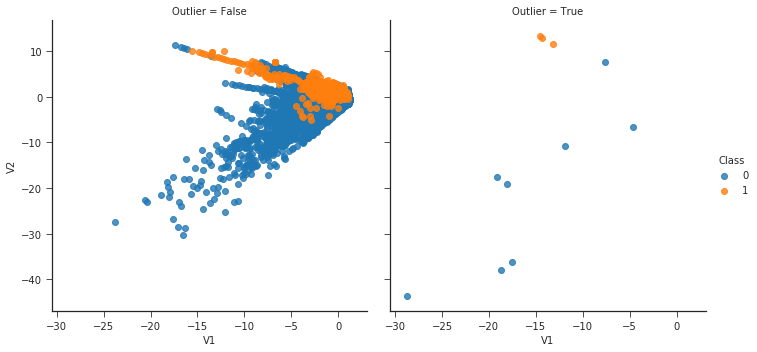

In [7]:
sns.lmplot('V1', 'V2', data=df_train, hue='Class', fit_reg=False, col='Outlier')

In [8]:
df_sampled = df_no_outlier.sample(n=30000, random_state=3)